# Classifier_ML

In [183]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # For the creation of the confusion matrix
from sklearn.metrics import classification_report # For the creation of precision, recall and f1-measures
from sklearn.metrics import accuracy_score # For help in comparing data given using accuracy score vs confusion matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

In [185]:
#Functions made:
def train_test_model(model, X_train, y_train, X_test, y_test):
    scaler= StandardScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled= scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    train_acc= model.score(X_train_scaled, y_train)
    test_acc= model.score(X_test_scaled, y_test)
    return {'train_acc':train_acc,'test_acc':test_acc} 

def transform_train_test_model(transformer, model, X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_reduced = transformer.fit_transform(X_train_scaled)
    X_test_reduced = transformer.transform(X_test_scaled)

    model.fit(X_train_reduced, y_train)
    train_acc = model.score(X_train_reduced, y_train)
    test_acc = model.score(X_test_reduced, y_test)
    return {'train_acc': train_acc, 'test_acc': test_acc}
#transform (produce the dimensionality of the data, i.e number of features)
#scale--> reduce dimensionality-> fit mode--> make predictions
#scale before reducing D, some dimensionality reduction methods, PCA in particular, are sensitive to the scale of the data

# Helper function to predict class labels
def predict_class_labels(classifier, X_train, y_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = classifier.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return y_pred

# Function to display the full results (confusion matrix, classification report)
def display_model_results_full(title, classifier, X_train, y_train, X_test, y_test):
    print(title + '. Full results')
    
    y_pred = predict_class_labels(classifier, X_train, y_train, X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot()
    plt.show() 
    
    print(classification_report(y_test, y_pred))
    print('\n')


In [187]:
df = pd.read_csv("classification.csv", header= None)
X = df.iloc[:, :-1]  # Independent features
y = df.iloc[:, -1]   # Dependent variable (last column of the dataset
test_frac=0.33
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size= test_frac, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size= test_frac, random_state=42) #67% training, 33% validation

In [189]:
#KNN model- captures non-linear decision boundaries
#Default kNN Validation accuracy:
def_kNN_val_acc= (train_test_model(KNeighborsClassifier(), X_dev, y_dev, X_val, y_val))
def_kNN_val_acc

{'train_acc': 0.8682634730538922, 'test_acc': 0.875}

In [191]:
#Training accuracy and Testing accuracy are more or less the same, model does not strongly overfit the data
#KNN vs Logistic regression --> KNN does a significantly better job

Best validation accuracy 0.8214285714285714 at d = 51


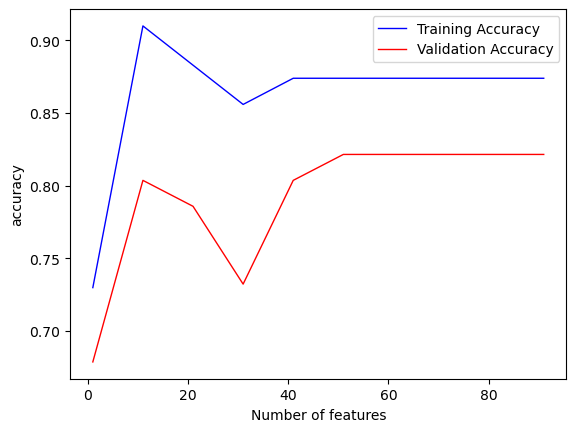

In [193]:
#apply PCA to the data:
random_state = np.random.RandomState(42)

# Loop over the candidate number of dimensions, storing the relevant training and validation accuracy so that we can plot it later.
dimensions = range(1, 100, 10) #change in steps of 10, expensive to compute
train_acc = []
val_acc = []
for d in dimensions:
    transformer = PCA(n_components=d, random_state=random_state)
    model = KNeighborsClassifier()
    res = transform_train_test_model(transformer, model, X_train, y_train, X_val, y_val)
    train_acc.append(res['train_acc'])
    val_acc.append(res['test_acc'])
index_min = np.argmax(val_acc)
print('Best validation accuracy {} at d = {}'.format(val_acc[index_min], dimensions[index_min]))

plt.xlabel('Number of features')
plt.ylabel('accuracy')
plt.plot(dimensions, train_acc, color='blue', linewidth=1, label='Training Accuracy')
plt.plot(dimensions, val_acc, color='red', linewidth=1, label='Validation Accuracy')
plt.legend()
#finding out the best number to reduce our dimensions to
#results based on a non-deterministic process
#PCA: has some random state--> the exact combinations of dimensions selected can be affected by random chance--> affect the performance of the model

Best validation accuracy 0.8392857142857143 at d = 36


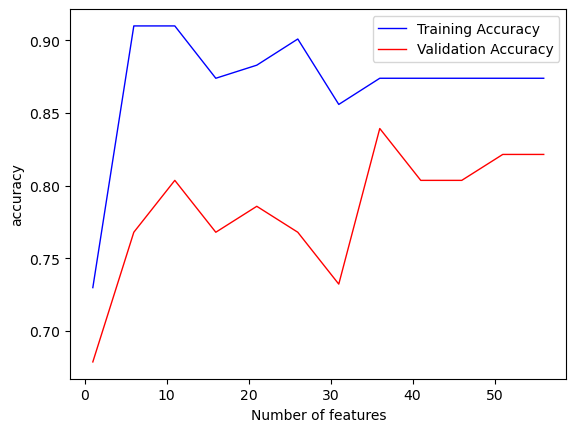

In [195]:
#reduce the range to find the specific number feature that maximises the accuracy of the model
dimensions = range(1, 60, 5)
train_acc = []
val_acc = []
n_repeats = 50 # Number of samples over which to take an average.
for d in dimensions:
    train_acc_partial = []
    test_acc_partial = []
    for _ in range(n_repeats):
        transformer = PCA(n_components=d, random_state=random_state)
        model = KNeighborsClassifier()
        
        res_partial = transform_train_test_model(transformer, model, X_train, y_train, X_val, y_val)
        train_acc_partial.append(res_partial['train_acc'])
        test_acc_partial.append(res_partial['test_acc'])
        
    train_acc.append(np.mean(train_acc_partial))
    val_acc.append(np.mean(test_acc_partial))
index_min = np.argmax(val_acc)
print('Best validation accuracy {} at d = {}'.format(val_acc[index_min], dimensions[index_min]))

plt.xlabel('Number of features')
plt.ylabel('accuracy')
plt.plot(dimensions, train_acc, color='blue', linewidth=1, label='Training Accuracy')
plt.plot(dimensions, val_acc, color='red', linewidth=1, label='Validation Accuracy')
plt.legend()


Best validation accuracy 0.8392857142857143 at d = 36


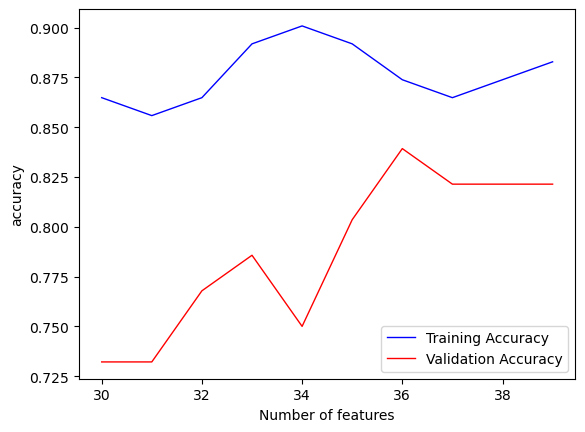

In [196]:
dimensions = range(30, 40, 1)
train_acc = []
val_acc = []
n_repeats = 50 # Number of samples over which to take an average.
for d in dimensions:
    train_acc_partial = []
    test_acc_partial = []
    for _ in range(n_repeats):
        transformer = PCA(n_components=d, random_state=random_state)
        model = KNeighborsClassifier()
        
        res_partial = transform_train_test_model(transformer, model, X_train, y_train, X_val, y_val)
        train_acc_partial.append(res_partial['train_acc'])
        test_acc_partial.append(res_partial['test_acc'])
        
    train_acc.append(np.mean(train_acc_partial))
    val_acc.append(np.mean(test_acc_partial))
index_min = np.argmax(val_acc)
print('Best validation accuracy {} at d = {}'.format(val_acc[index_min], dimensions[index_min]))

plt.xlabel('Number of features')
plt.ylabel('accuracy')
plt.plot(dimensions, train_acc, color='blue', linewidth=1, label='Training Accuracy')
plt.plot(dimensions, val_acc, color='red', linewidth=1, label='Validation Accuracy')
plt.legend()
#reduced dimensionality where the dataset contained 36 features- A kNN classifier in 36 dimensions will be our model.
#Best validation accuracy is achieved when the dimensionality is reduced to 36 features. 
#Want to see if reducing dimensionalities will make the model more accurate? Default KNN vs Reduced dimensions KNN

Default kNN test accuracy
{'train_acc': 0.8682634730538922, 'test_acc': 0.8795180722891566}
Reduced kNN test accuracy
{'train_acc': 0.8682634730538922, 'test_acc': 0.8674698795180723}
Best parameters for kNN: {'n_neighbors': 3}
Best cross-validated accuracy for kNN: 0.775098814229249
kNN Test Accuracy: 0.8674698795180723
kNN Test F1 Score: 0.8646404744255003
Default KNN: tested on training data. Full results


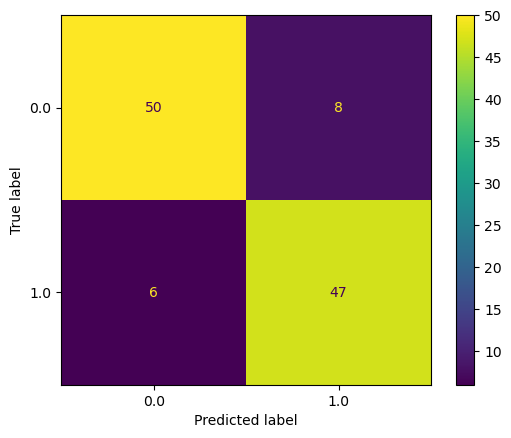

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88        58
         1.0       0.85      0.89      0.87        53

    accuracy                           0.87       111
   macro avg       0.87      0.87      0.87       111
weighted avg       0.87      0.87      0.87       111



Default KNN: tested on test data. Full results


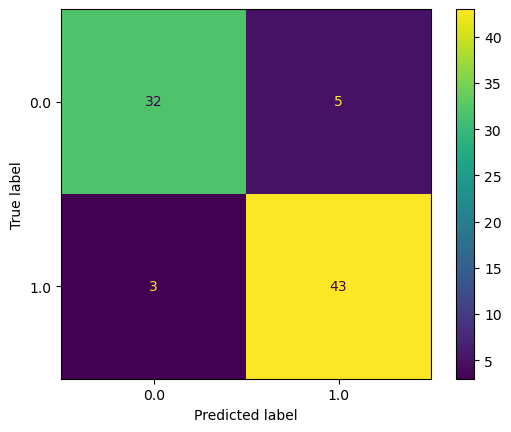

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89        37
         1.0       0.90      0.93      0.91        46

    accuracy                           0.90        83
   macro avg       0.91      0.90      0.90        83
weighted avg       0.90      0.90      0.90        83





In [197]:
# KNN classification algorithms- evaluating if reducing the dimensionality of the dataset would improve the generalisation performance of the model
print('Default kNN test accuracy')
print(train_test_model(KNeighborsClassifier(), X_dev, y_dev, X_test, y_test))

print('Reduced kNN test accuracy')
transformer = PCA(n_components=36)
model = KNeighborsClassifier()
print(transform_train_test_model(transformer, model, X_dev, y_dev, X_test, y_test))

# Define the range of k values to search for the optimal k
knn_param_grid = {
    'n_neighbors': range(1, 21)  # Testing k values from 1 to 20
}

# Using GridSearchCV to find the best number of neighbours
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# Get the best parameters and score for kNN
best_knn = knn_grid_search.best_estimator_
print("Best parameters for kNN:", knn_grid_search.best_params_)
print("Best cross-validated accuracy for kNN:", knn_grid_search.best_score_)

# Evaluate the best kNN model on the test data
y_pred_knn = best_knn.predict(X_test)
print("kNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("kNN Test F1 Score:", f1_score(y_test, y_pred_knn, average='macro'))
display_model_results_full('Default KNN: tested on training data', model, X_train, y_train, X_train, y_train)
display_model_results_full('Default KNN: tested on test data', model, X_test, y_test, X_test, y_test)

In [198]:
#Full dimensionality dataset's test accuracy is outperforming by 1.25%. 
#The curse of dimensionality did not come into play here however test accuracies was quite similar

Best parameters for SVC: {'C': 1, 'gamma': 0.01}
Best cross-validated accuracy for SVC: 0.8205533596837945


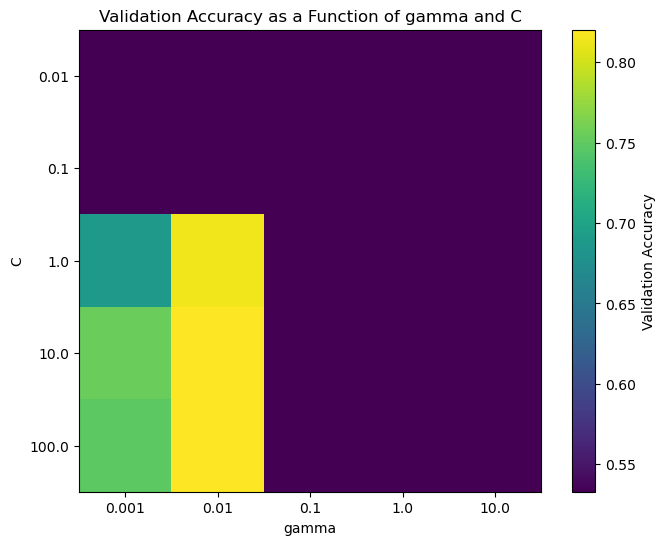

SVC Test Accuracy: 0.7951807228915663
SVC Test F1 Score: 0.7921637943732509
Accuracy: 0.4457831325301205


In [199]:
#SVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning for SVC with RBF kernel
svc_param_grid = {
    'C': [0.1, 1, 10, 100],          # Range of C values to control regularisation
    'gamma': [0.001, 0.01, 0.1, 1]   # Range of gamma values to control the influence of individual data points
}

# Using GridSearchCV to find the best parameters
svc_grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), svc_param_grid, cv=5, scoring='accuracy')
svc_grid_search.fit(X_train, y_train)

# Get the best parameters and score for SVC
best_svc = svc_grid_search.best_estimator_
print("Best parameters for SVC:", svc_grid_search.best_params_)
print("Best cross-validated accuracy for SVC:", svc_grid_search.best_score_)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# Define a range of values for C and gamma to explore
C_range = np.logspace(-2, 2, 5)  # e.g., [0.01, 0.1, 1, 10, 100]
gamma_range = np.logspace(-3, 1, 5)  # e.g., [0.001, 0.01, 0.1, 1, 10]

# Set up parameter grid for grid search
param_grid = {'svc__C': C_range, 'svc__gamma': gamma_range}

# Create a pipeline that includes scaling and SVC with RBF kernel
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# Perform grid search with cross-validation to collect validation accuracy
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Extract grid search results
scores = grid_search.cv_results_['mean_test_score']
scores = scores.reshape(len(C_range), len(gamma_range))

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='Validation Accuracy')
plt.xticks(np.arange(len(gamma_range)), labels=np.round(gamma_range, 3))
plt.yticks(np.arange(len(C_range)), labels=np.round(C_range, 3))
plt.title('Validation Accuracy as a Function of gamma and C')
plt.show()

# Evaluate the best SVC model on the test data
y_pred_svc = best_svc.predict(X_test)
print("SVC Test Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVC Test F1 Score:", f1_score(y_test, y_pred_svc, average='macro'))
# Create a kernel support vector machine model
ksvm = svm.SVC(kernel='rbf',
			gamma=0.1,
			C=10.0)

# Train the model on the training data
ksvm.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = ksvm.score(X_test, y_test)
print('Accuracy:', accuracy)


Kernel: linear
Training Accuracy: 0.8922155688622755
Testing Accuracy: 0.43373493975903615
Kernel: poly
Training Accuracy: 0.8143712574850299
Testing Accuracy: 0.4939759036144578
Kernel: rbf
Training Accuracy: 0.9461077844311377
Testing Accuracy: 0.7590361445783133
Kernel: sigmoid
Training Accuracy: 0.6467065868263473
Testing Accuracy: 0.5662650602409639
RBF SVC: tested on training data. Full results


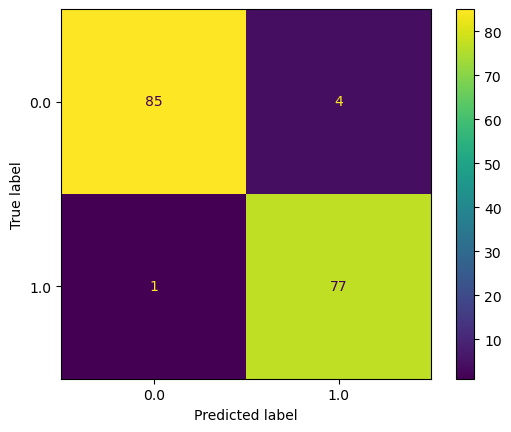

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97        89
         1.0       0.95      0.99      0.97        78

    accuracy                           0.97       167
   macro avg       0.97      0.97      0.97       167
weighted avg       0.97      0.97      0.97       167



RBF SVC: tested on test data. Full results


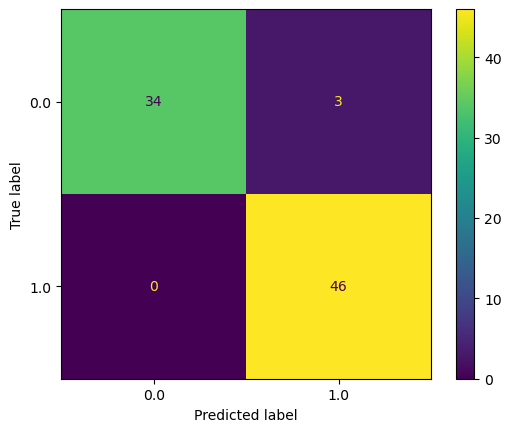

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        37
         1.0       0.94      1.00      0.97        46

    accuracy                           0.96        83
   macro avg       0.97      0.96      0.96        83
weighted avg       0.97      0.96      0.96        83





In [200]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_accuracies = {}
test_accuracies = {}

for kernel in kernels:
    svc = SVC(kernel=kernel, random_state= random_state)
    svc.fit(X_train, y_train)
    train_accuracies[kernel] = accuracy_score(y_train, svc.predict(X_train))
    test_accuracies[kernel] = accuracy_score(y_test, svc.predict(X_test))

# Print the accuracies for each kernel
for kernel in kernels:
    print(f"Kernel: {kernel}")
    print(f"Training Accuracy: {train_accuracies[kernel]}")
    print(f"Testing Accuracy: {test_accuracies[kernel]}")

#looking at the different SVC accuracy values, the smallest variance shown in the model is RBF Kernal 

display_model_results_full('RBF SVC: tested on training data', SVC(kernel='rbf'), X_train, y_train, X_train, y_train)
display_model_results_full('RBF SVC: tested on test data', SVC(kernel='rbf'), X_test, y_test, X_test, y_test)